# Predicting NYC Taxi Fares with RAPIDS

[RAPIDS](https://rapids.ai/) is a suite of GPU accelerated data science libraries with APIs that should be familiar to users of Pandas, Dask, and Scikitlearn.

Anaconda has graciously made some of the NYC Taxi dataset available in [a public Google Cloud Storage bucket](https://console.cloud.google.com/storage/browser/anaconda-public-data/nyc-taxi/csv/).

This notebook builds a simple data pipeline to load the data with cuDF (or Pandas), analyze it with cuML (or scikit-learn), and then try some steps with multiple GPUs.

In [1]:
import numpy as np
import pandas as pd
import cuml
import cudf
import os

# Inspecting the Data

Let's start with a familiar Pandas approach then port it to RAPIDS in parallel

In [2]:
!ls ../../data/nyc-taxi/2014

yellow_tripdata_2014-01.csv    yellow_tripdata_2014-07.csv
yellow_tripdata_2014-01.csv.1  yellow_tripdata_2014-08.csv
yellow_tripdata_2014-02.csv    yellow_tripdata_2014-09.csv
yellow_tripdata_2014-03.csv    yellow_tripdata_2014-10.csv
yellow_tripdata_2014-04.csv    yellow_tripdata_2014-11.csv
yellow_tripdata_2014-05.csv    yellow_tripdata_2014-12.csv
yellow_tripdata_2014-06.csv


In [3]:
base_path = '../../data/nyc-taxi/'

In [4]:
%%time
# Pandas

df_2014 = pd.read_csv(base_path+'2014/yellow_tripdata_2014-03.csv')
df_2014.head()

<string>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 29.6 s, sys: 4.02 s, total: 33.6 s
Wall time: 33.6 s


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-03-01 01:07:38,2014-03-01 01:16:26,1,2.0,-73.951504,40.714113,1,N,-73.944278,40.690677,CRD,9.0,0.5,0.5,2.0,0.0,12.0
1,CMT,2014-03-01 01:08:03,2014-03-01 01:12:51,2,1.2,-74.004735,40.742173,1,N,-73.992228,40.748210,CRD,6.0,0.5,0.5,1.0,0.0,8.0
2,CMT,2014-03-01 01:08:51,2014-03-01 01:13:18,3,0.5,-73.949302,40.707569,1,N,-73.951654,40.714250,CRD,5.0,0.5,0.5,1.2,0.0,7.2
3,CMT,2014-03-01 01:09:20,2014-03-01 01:24:18,3,3.5,-73.993539,40.721300,1,N,-73.961437,40.760412,CRD,14.0,0.5,0.5,3.0,0.0,18.0
4,CMT,2014-03-01 01:09:46,2014-03-01 01:22:34,1,1.8,-73.987881,40.744579,1,N,-74.004384,40.722775,CRD,10.5,0.5,0.5,1.0,0.0,12.5


In [82]:
%%time
# TODO: Read the CSV with cudf into gdf_2014


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 29.6 µs


# Data Cleanup

As usual, the data needs to be massaged a bit before we can start adding features that are useful to an ML model.

For example, in the 2014 taxi CSV files, there are `pickup_datetime` and `dropoff_datetime` columns.

Also, some CSV files have column names with extraneous spaces in them.

We'll do a little string manipulation, column renaming, and concatenating of DataFrames to sidestep the problems.

In [6]:
# list of column names that need to be re-mapped
remap = {}
remap['tpep_pickup_datetime'] = 'pickup_datetime'
remap['tpep_dropoff_datetime'] = 'dropoff_datetime'
remap['ratecodeid'] = 'rate_code'

# create a list of columns & dtypes the df must have
# note that float64 will be significantly slower on some GPUs (most GeForce, also Tesla T4)
must_haves = {
 'pickup_datetime': 'datetime64[ms]',
 'dropoff_datetime': 'datetime64[ms]',
 'passenger_count': 'int32',
 'trip_distance': 'float',
 'pickup_longitude': 'float',
 'pickup_latitude': 'float',
 'rate_code': 'int32',
 'dropoff_longitude': 'float',
 'dropoff_latitude': 'float',
 'fare_amount': 'float'
}

In [7]:
# helper function which takes a DataFrame and fixes column types
def clean_columns(df_part, remap, must_haves, float_type):    
    # iterate through columns in this df
    for col in df_part.columns:
        # drop anything not in our expected list
        if col not in must_haves:
            print(f"Dropping ({col})")
            df_part = df_part.drop(columns=col)
            continue
        
        if df_part[col].dtype == 'object' and col in ['pickup_datetime', 'dropoff_datetime']:
            df_part[col] = df_part[col].astype('datetime64[ms]')
            continue
                
        # if column was read as a string, recast as float
        if df_part[col].dtype == 'object':
            df_part[col] = df_part[col].str.fillna('-1')
            df_part[col] = df_part[col].astype('float32')
        else:
            # downcast from 64bit to 32bit types
            # Tesla T4 are faster on 32bit ops
            if 'int' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('int32')
            if 'float' in str(df_part[col].dtype):
                # CPU-based pandas has a bug preventing query use with fp32 columns
                df_part[col] = df_part[col].astype(float_type)
            df_part[col] = df_part[col].fillna(-1)
    
    return df_part

In [8]:
%%time
# Pandas approach

# some col-names include pre-pended spaces remove & lowercase column names
col_cleanup = {col: col.strip().lower() for col in list(df_2014.columns)}
df = df_2014.rename(columns=col_cleanup)
# rename columns using the supplied mapping
df = df.rename(remap)

df = clean_columns(df, remap, must_haves, np.float64)
print(df.__class__)
print(df.head(1))

Dropping (vendor_id)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (surcharge)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (total_amount)
<class 'pandas.core.frame.DataFrame'>
      pickup_datetime    dropoff_datetime  passenger_count  trip_distance  \
0 2014-03-01 01:07:38 2014-03-01 01:16:26                1            2.0   

   pickup_longitude  pickup_latitude  rate_code  dropoff_longitude  \
0        -73.951504        40.714113          1         -73.944278   

   dropoff_latitude  fare_amount  
0         40.690677          9.0  
CPU times: user 19.1 s, sys: 10.6 s, total: 29.7 s
Wall time: 29.7 s


In [83]:
%%time
# TODO: RAPIDS approach - same as Pandas, but generate 'gdf' as output


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 32.7 µs


# Look at some key stats

In [10]:
import seaborn as sns

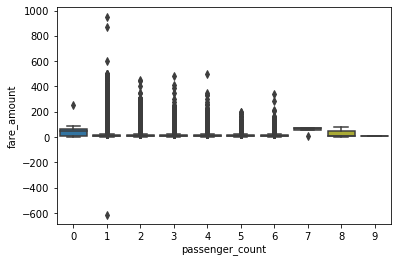

In [11]:
sns.boxplot(x="passenger_count", y="fare_amount", data=gdf.to_pandas())

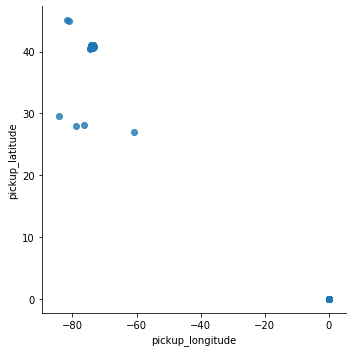

In [12]:
sns.lmplot(x="pickup_longitude", y="pickup_latitude",
           data=gdf.head(100000).to_pandas(),
           fit_reg=False,
           x_jitter=0.01, y_jitter=0.01)

# Filter the data

In [13]:
%%time

# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75.0 and pickup_longitude < -73.0',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42'
]
df_subset = df.query(' and '.join(query_frags)).copy()

# inspect the results of cleaning
df_subset.head()

CPU times: user 1.05 s, sys: 940 ms, total: 1.99 s
Wall time: 1.99 s


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-03-01 01:07:38,2014-03-01 01:16:26,1,2.0,-73.951504,40.714113,1,-73.944278,40.690677,9.0
1,2014-03-01 01:08:03,2014-03-01 01:12:51,2,1.2,-74.004735,40.742173,1,-73.992228,40.748210,6.0
2,2014-03-01 01:08:51,2014-03-01 01:13:18,3,0.5,-73.949302,40.707569,1,-73.951654,40.714250,5.0
3,2014-03-01 01:09:20,2014-03-01 01:24:18,3,3.5,-73.993539,40.721300,1,-73.961437,40.760412,14.0
4,2014-03-01 01:09:46,2014-03-01 01:22:34,1,1.8,-73.987881,40.744579,1,-74.004384,40.722775,10.5


In [84]:
%%time

# TODO: RAPIDS version with "gdf_subset" as output


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 31.9 µs


# Demo 3: UDFs to add rich features 

cuDF provides standard DataFrame operations, but also let you run "user defined functions" on the underlying data.

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

We'll use a Haversine Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.

In [15]:
from numpy import pi

def haversine_distance_kernel_cpu(row):
    x_1, y_1, x_2, y_2 = (row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"])
    x_1 = pi/180 * x_1
    y_1 = pi/180 * y_1
    x_2 = pi/180 * x_2
    y_2 = pi/180 * y_2

    dlon = y_2 - y_1
    dlat = x_2 - x_1
    a = np.sin(dlat/2)**2 + np.cos(x_1) * np.cos(x_2) * np.sin(dlon/2)**2

    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
        
    return c * r
        
def add_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    
    df['pickup_latitude_r'] = df['pickup_latitude']//.01*.01
    df['pickup_longitude_r'] = df['pickup_longitude']//.01*.01
    df['dropoff_latitude_r'] = df['dropoff_latitude']//.01*.01
    df['dropoff_longitude_r'] = df['dropoff_longitude']//.01*.01
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    
    df = df.drop(columns=['pickup_datetime', 'dropoff_datetime'])    
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int32)
    return df

In [16]:
%%time

# actually add the features
taxi_df = add_features(df_subset)

CPU times: user 4.99 s, sys: 3.24 s, total: 8.23 s
Wall time: 8.23 s


In [17]:
%%time
# compute distance
taxi_df["h_distance"] = haversine_distance_kernel_cpu(taxi_df)

CPU times: user 1.02 s, sys: 844 ms, total: 1.86 s
Wall time: 1.85 s


## cuDF version with UDF

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

In [18]:
import math
from math import cos, sin, asin, sqrt, pi

def haversine_distance_kernel_gpu(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, h_distance):
    for i, (x_1, y_1, x_2, y_2) in enumerate(zip(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)):
        x_1 = pi/180 * x_1
        y_1 = pi/180 * y_1
        x_2 = pi/180 * x_2
        y_2 = pi/180 * y_2
        
        dlon = y_2 - y_1
        dlat = x_2 - x_1
        a = sin(dlat/2)**2 + cos(x_1) * cos(x_2) * sin(dlon/2)**2
        
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Radius of earth in kilometers
        
        h_distance[i] = c * r

def day_of_the_week_kernel(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] <3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m*2.6) + y + (y//4) + (c//4) -2*c)%7
        
def add_features_gpu(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    
    df['pickup_latitude_r'] = df['pickup_latitude']//.01*.01
    df['pickup_longitude_r'] = df['pickup_longitude']//.01*.01
    df['dropoff_latitude_r'] = df['dropoff_latitude']//.01*.01
    df['dropoff_longitude_r'] = df['dropoff_longitude']//.01*.01
    # df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    # cuDF does not support dayofweek yet, coming soon though: https://github.com/rapidsai/cudf/pull/2814
    
    #
    # Auto-JIT kernels
    #
    df = df.apply_rows(day_of_the_week_kernel,
                      incols=['day', 'month', 'year'],
                      outcols=dict(day_of_week=np.float32),
                      kwargs=dict())
    df = df.drop(columns=['pickup_datetime', 'dropoff_datetime'])    

 
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int32)
    return df

def compute_distance_gpu(df):
    df = df.apply_rows(haversine_distance_kernel_gpu,
                   incols=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
                   outcols=dict(h_distance=np.float32),
                   kwargs=dict())
    return df

In [85]:
%%time

# TODO: actually add the features and create "taxi_gdf" from gdf_subset

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 32.9 µs


In [86]:
%%time

# TODO: add the distance calculation

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 27.2 µs


For more advanced spatial calculations, check out cuSpatial (https://medium.com/rapids-ai/releasing-cuspatial-to-accelerate-geospatial-and-spatiotemporal-processing-b686d8b32a9), the newest RAPIDS library.

In [87]:
# TODO: Print summary stats from "taxi_gdf"

# Pick a Training Set

Let's imagine you're making a trip to New York on the 24th and want to build a model to predict what fare prices will be like the last few days of the month based on the first part of the month. We'll use a query expression to identify the `day` of the month to use to divide the data into train and test sets.

The wall-time below represents how long it takes your GPU cluster to load data from the Google Cloud Storage bucket and the ETL portion of the workflow.

In [22]:
%%time
X_train_df = taxi_df.query('day < 24')
Y_train_df = X_train_df[['fare_amount']]
X_train_df = X_train_df.drop(columns='fare_amount')

# numpy versions for sklearn
X_train_np = X_train_df.to_numpy()
Y_train_np = Y_train_df.to_numpy()
len(X_train_df)

CPU times: user 1.52 s, sys: 3.06 s, total: 4.58 s
Wall time: 4.58 s


10876536

In [23]:
from cuml.utils import input_utils # Helpful functions for managing gpu arrays

In [24]:
%%time
X_train_gdf = taxi_gdf.query('day < 24')
Y_train_gdf = X_train_gdf[['fare_amount']]
X_train_gdf = X_train_gdf.drop(columns='fare_amount')

# gpu matrix versions for cuml
X_train_gpu = input_utils.input_to_dev_array(X_train_gdf, convert_to_dtype=np.float32).array
Y_train_gpu = input_utils.input_to_dev_array(Y_train_gdf, convert_to_dtype=np.float32).array

# test versions
X_test_gdf = taxi_gdf.query('day >= 24')
Y_test_gdf = X_test_gdf[['fare_amount']]
X_test_gdf = X_test_gdf.drop(columns='fare_amount')

X_test_gpu = input_utils.input_to_dev_array(X_test_gdf, convert_to_dtype=np.float32).array
Y_test_gpu = input_utils.input_to_dev_array(Y_test_gdf, convert_to_dtype=np.float32).array


len(X_train_gdf)

CPU times: user 436 ms, sys: 360 ms, total: 796 ms
Wall time: 830 ms


10876536

# Demo 4: Cluster and analyze with cuML

In [25]:
%matplotlib inline

In [26]:
import sklearn, sklearn.cluster
from matplotlib import pyplot as plt

In [27]:
%%time
# use scikit-learn on CPU

sk_kmeans = sklearn.cluster.KMeans(n_clusters=5, n_jobs=-1)
train_clusters_cpu = sk_kmeans.fit_predict(X_train_np[:200000,:])

CPU times: user 252 ms, sys: 19.5 s, total: 19.8 s
Wall time: 21.4 s


In [88]:
%%time
n_samples = 400000

# TODO: use cuML on GPU to fit KMeans with 5 clusters (larger dataset)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 37.9 µs


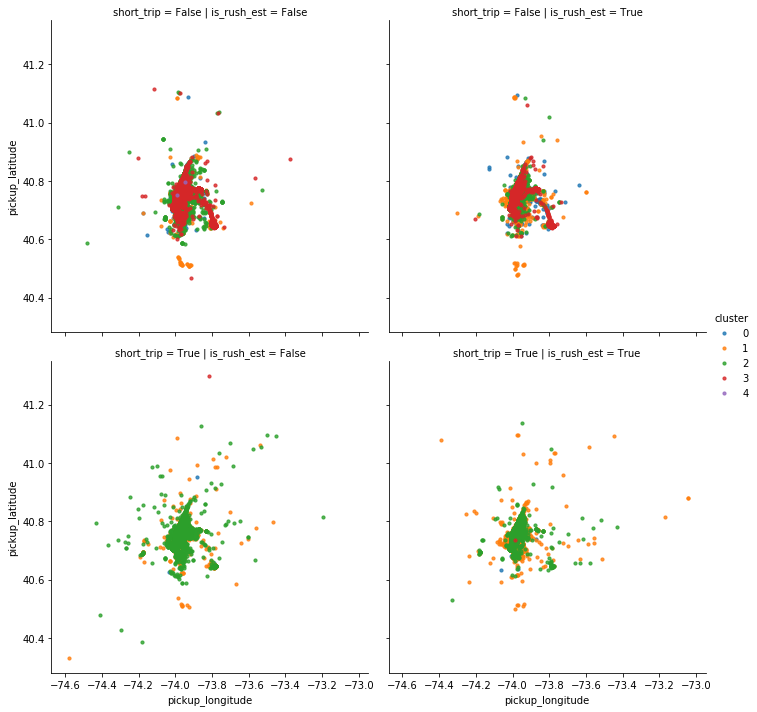

In [29]:
# Just take a subset to speed plotting
gdf_train_head = X_train_gdf.iloc[:400000]
gdf_train_head["cluster"] = train_clusters_gpu[:400000]
gdf_train_head["short_trip"] = gdf_train_head["trip_distance"] < 1.01 # About the 25th percentile
gdf_train_head["is_rush_est"] = ((gdf_train_head.hour >= 10) & (gdf_train_head.hour <= 14)) | \
                                ((gdf_train_head.hour >= 21) & (gdf_train_head.hour <= 24))

# actually do the plot
sns.lmplot("pickup_longitude", "pickup_latitude", data=gdf_train_head.to_pandas(),
           hue="cluster", col="is_rush_est", row="short_trip", fit_reg=False, scatter_kws={"s": 10})

### Fit a simple supervised model with cuML

cuML supports a large range of supervised models, all emulating the scikit-learn interfaces. See the README (https://github.com/rapidsai/cuml) for a recent list. Here, we'll try a very simple model - a regularized linear regression with the ElasticNet approach that blends L1 and L2 penalties.

In [30]:
from sklearn.linear_model import ElasticNet as skElastic
from cuml.linear_model import ElasticNet as cuElastic

In [31]:
%%time
# Sklearn will parallelize over all CPU cores with n_jobs=-1
sk_model = skElastic(alpha=0.1)
sk_model.fit(X_train_np, Y_train_np)

CPU times: user 3min 39s, sys: 1min 34s, total: 5min 14s
Wall time: 6.72 s


ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [89]:
%%time

# TODO: Build a similar model on GPU with cuML

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 30.3 µs


In [90]:
%%time

# Predict on a test set (storing as "enet_predictions" in the Y_test_gdf df)
# and evaluate the predictions' R2 score

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 38.1 µs


# Demo 5: Train an  XGBoost Regression Model

XGBoost is one of the most popular packages for gradient boosted decision trees. It comes with excellent GPU acceleration out of the box.

In [34]:
%%time
# Train on CPU (uses all CPUs by default)
import xgboost

params = {
 'learning_rate': 0.3,
  'max_depth': 6,

  'subsample': 0.6,
  'gamma': 1
}

train_dmat = xgboost.DMatrix(X_train_np, Y_train_np, feature_names=X_train_df.columns)
print("Converted to dmatrix")
trained_model = xgboost.train(params, train_dmat, num_boost_round=5)

Converted to dmatrix
[22:44:36] WARNING: /conda/conda-bld/xgboost_1571337743864/work/src/gbm/gbtree.cc:130: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 7min 52s, sys: 27.3 s, total: 8min 19s
Wall time: 38.1 s


In [91]:
%%time
# TODO: retrain on GPU for more rounds, saving model as trained_model_gpus

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 32.2 µs


# How Good is Our Model?

Now that we have a trained model, we need to test it with the ecords we held out.

In [92]:
%%time

# TODO: generate predictions on the test set as Y_test_gdf['prediction']

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 60.6 µs


# Compute Root Mean Squared Error

In [39]:
Y_test_gdf["squared_error"] = (Y_test_gdf['prediction'] - Y_test_gdf['fare_amount'])**2

# inspect the results to make sure our calculation looks right
Y_test_gdf.head()

,fare_amount,enet_predictions,prediction,squared_error
813929,9.0,10.702911,9.266807,0.071186
835025,9.5,10.802237,9.434024,0.004353
837538,8.5,9.288425,8.752668,0.063841
838538,23.0,18.593967,20.429344,6.608271
840424,9.0,8.981359,8.653069,0.120361


In [40]:
# compute the actual RMSE over the full test set
np.sqrt(Y_test_gdf.squared_error.mean())

2.3268684915223186

# Save Trained Model for Later Use

To make a model maximally useful, you need to be able to save it for later use.

In [41]:
# Save model
trained_model_gpu.save_model("output.model")

# Demo 6: A quick intro to Dask + RAPIDS

Dask is a sophisticated package for parallel computation with a number of different datatypes. For much more detail, see: https://tutorial.dask.org/

In these examples, we'll focus on the basics of `dask_cudf` and `dask_cuda`

In [42]:
import dask_cudf

In [43]:
import dask, dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait

In [44]:
# Setup a cluster and connect a client to it

cluster = LocalCUDACluster()
client = Client(cluster)

In [45]:
client

Client Scheduler: tcp://127.0.0.1:39427 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 540.95 GB


In [46]:
%%time
ddf_all2014 = dask_cudf.read_csv(base_path+'2014/yellow_*.csv')

CPU times: user 156 ms, sys: 24 ms, total: 180 ms
Wall time: 181 ms


In [ ]:
len(ddf_all2014)

In [47]:
# Redo the same cleanup we used above but on Dask this time

col_cleanup = {col: col.strip().lower() for col in list(df_2014.columns)}
ddf = ddf_all2014.rename(columns=col_cleanup)
# rename columns using the supplied mapping
ddf = ddf.rename(columns=remap)

ddf = clean_columns(ddf, remap, must_haves, np.float64)

Dropping (vendor_id)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (surcharge)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (total_amount)


In [49]:
# Compute a simple histogram of passengers

value_counts = ddf.passenger_count.value_counts()
print(value_counts)
print(value_counts.compute())

<dask_cudf.Series | 7387 tasks | 1 npartitions>


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:55080 remote=tcp://127.0.0.1:39427>


1      116291354
2       23058951
5        9275848
3        6971325
6        6123895
4        3386103
0           6502
7            137
9            127
8             98
208           21
Name: passenger_count, dtype: int64


## Machine learning with Dask

See also XGBoost's Dask interface docs: https://github.com/dmlc/xgboost/tree/master/demo/dask

In [51]:
# Use map_partitions to apply the same distance function we used before
ddf_with_dist = ddf.map_partitions(compute_distance_gpu)
ddf_with_dist.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,h_distance
0,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994770,40.736828,1,-73.982227,40.731790,6.5,1.196132
1,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982392,40.773382,1,-73.960449,40.763995,8.5,2.122317
2,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988570,40.739406,1,-73.986626,40.765217,11.5,2.874720
3,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770464,1,-73.979863,40.777050,7.5,1.809489
4,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995371,40.717248,1,-73.984367,40.720524,6.0,0.996360


In [52]:
kmeans_cols = ["passenger_count", "trip_distance", "rate_code", "fare_amount", "h_distance"]

In [80]:
%%time
X_ddf = ddf_with_dist[kmeans_cols]
for c in X_ddf.columns:
    X_ddf[c] = X_ddf[c].astype(np.float32)
Y_ddf = X_ddf["fare_amount"]
X_ddf = X_ddf.drop(columns="fare_amount")

X_ddf, y_ddf = client.persist([X_ddf, Y_ddf]) # Trigger the computation and cache in RAM
_ = wait([X_ddf, y_ddf]) # Actually wait for persistence to finish

CPU times: user 24.6 s, sys: 3.8 s, total: 28.3 s
Wall time: 1min 24s


In [70]:
import xgboost
from xgboost.dask import DaskDMatrix

In [93]:
%%time

params = {'verbosity': 2, 'nthread': 1, 'tree_method': 'gpu_hist', 'objective': 'reg:squarederror',}

# TODO: create a dmatrix, train a model, and store as xgb_model

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 33.6 µs


In [75]:
# TODO: explore within-train-sample predictions